In [2]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import TransformerMixin
from torch import nn
from torch.utils.data import DataLoader

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs = 1, n_layers = 1, n_neurons_per_layer = None, leaky_slope = 0.01):
        if n_layers > 0:
            try:
                assert n_neurons_per_layer is not None
                assert len(n_neurons_per_layer) == n_layers
            except Exception as e:
                raise ValueError("provide numbers of neurons per layer defined by n_layers")
        
        super().__init__()
        self.flatten = nn.Flatten()
        if n_layers >= 1:
            stack = [ nn.Linear( n_inputs, n_neurons_per_layer[0] ) ]
            for k in range(n_layers-1):
                stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[k], n_neurons_per_layer[k+1]) ]
            stack += [ nn.LeakyReLU(leaky_slope), nn.Linear(n_neurons_per_layer[n_layers-1], n_outputs) ]
        else:
            stack = [ nn.Linear( n_inputs, n_outputs ) ]
        
        self.linear_relu_stack = nn.Sequential( *stack )
        self.prob_predictor = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        for name, param in self.named_parameters():
            param.data.uniform_(-0.5,0.5)
            
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    def predict(self, x):
        logits = self.forward(x)
        return self.prob_predictor(logits)
    
    def loss_fn(self, x, y):
        logits = self.forward(x)
        return self.loss(logits, y)

In [4]:
def load_dataset(filepath):
    with open(filepath, "r") as f:
        dataset = [ json.loads(line, parse_int = str) for line in f ]
    return dataset

def get_vectorizer( texts: list[str], *, method="countvectorize", **kwargs ) -> CountVectorizer:
    """From a list of texts, output an appropriate vectorizer either using CountVectorizer or TF-IDF depending on method argument. 

     Args:
         texts (list[str]): list of strings, each item corresponding to a text.
         method (str, optional): Method to select features. Defaults to "count-vectorizer".
         **kwargs: kwarg arguments to pass to Vectorizer classes of sklearn.
    Raises:
        ValueError: If passing an non-specified method of text feature extraction

     Returns:
         pd.DataFrame: dataframe of shape (n_samples, n_features)
    """
    #We want single digits to be tokenized. This regex considers everything as a token except whitespace.
    kwargs['token_pattern'] = r'\S+' 
    if method == "countvectorize":
        vectorizer = CountVectorizer(**kwargs)
    elif method == "tfidf":
        vectorizer = TfidfVectorizer(**kwargs)
    else:
        raise ValueError(f"{method} is not a supported method.")
    #Use texts to initialize vocabulary of vectorizer
    vectorizer.fit(texts)
    return vectorizer

def sentencify(text: list) -> str:
    sentence = " ".join(text) 
    return sentence

def loss(clf, X, y):
    probs = clf.predict_log_proba(X)
    y0 = probs[:,1]
    y1 = probs[:,0]
    loss = -y*y0 - (1-y)*y1
    loss = loss.sum()/y.size
    return loss

def balanced_acc(clf, X, y):
    y_pred = clf.predict(X)
    return balanced_accuracy_score(y, y_pred, adjusted=True)

class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [5]:
dataset_1 = load_dataset("domain1_train_data.json")
datatexts_1 = [ sentencify(instance['text']) for instance in dataset_1 ]

In [6]:
tfidf_vectorizer = get_vectorizer( texts = datatexts_1,
                                    method='tfidf',
                                    use_idf=True,
                                    ngram_range=(1,3),
                                    max_df=0.999, #Ignore vocabulary appearing too frequently, probably words like "is", "are", "and", "this" etc.
                                    min_df=2, #Ignore vocabulary that is too infrequent, as this may lead to low prediction accuracy.
                                    )
print(f"no features: {tfidf_vectorizer.get_feature_names_out().size}")

In [7]:
X1 = tfidf_vectorizer.transform( datatexts_1 ).toarray()
y = np.array([1]*2500 + [0]*2500)

X1_extended = np.zeros( (X1.shape[0], X1.shape[1] + 2) )
X1_extended[:,:X1.shape[1]] = X1
for i in range(X1.shape[0]):
    for k in range(2):
        X1_extended[i,X1.shape[1]+k] = len(dataset_1[i]['text'])**(k+1)
del X1

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X1_extended.astype(float), y.astype(float),
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1,
                                                    stratify=y
                                                   )

In [9]:
scaler = StandardScaler()
selector = SelectFromModel( LogisticRegression(C=0.1, random_state=0) )
X_train = selector.fit_transform( scaler.fit_transform(X_train), y_train )
X_test = selector.transform( scaler.transform(X_test) )

In [10]:
mps_device = torch.device("mps")
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().reshape(-1,1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().reshape(-1,1)
X_train = X_train.to(mps_device)
y_train = y_train.to(mps_device)
X_test = X_test.to(mps_device)
y_test = y_test.to(mps_device)
train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=X_train.shape[0]//10)

In [12]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [13]:
torch.manual_seed(1)
model = NeuralNetwork( X_train.shape[1], 1, 1, [500] )
model.to(mps_device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=66823, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=500, out_features=1, bias=True)
  )
  (prob_predictor): Sigmoid()
  (loss): BCEWithLogitsLoss()
)

In [14]:
def train_epochs(n_epochs, learning_rate, weight_decay):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(n_epochs):
        mean_trainloss = 0
        num_trainbatches = len(train_dataloader)
        
        #Begin training
        model.train()
        for X_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            loss = model.loss_fn(X_batch, y_batch)
            mean_trainloss += loss.item()
            loss.backward()
            optimizer.step()
        mean_trainloss /= num_trainbatches
        train_losses += [ mean_trainloss ]
        
        #Begin evaluation
        model.eval()
        with torch.no_grad():
            testloss = model.loss_fn(X_test, y_test).item()
            test_losses += [testloss]
            y_pred = model.predict(X_test)
            accuracy = ( y_pred.round() == y_test ).float().mean().item()
            test_accuracy += [accuracy]
            
            y_pred = model.predict(X_train)
            accuracy = ( y_pred.round() == y_train ).float().mean().item()
            train_accuracy += [accuracy]
        print(f'Finished epoch {epoch}, latest trainloss {np.round(mean_trainloss,4)}, testloss {np.round( testloss, 4 )}, test accuracy {np.round(test_accuracy[-1],4)}')
    return train_losses, test_losses, train_accuracy, test_accuracy

In [15]:
train_1 = train_epochs(n_epochs=20, learning_rate=0.01, weight_decay=0.0)

Finished epoch 0, latest trainloss 88.6528, testloss 234.9544, test accuracy 0.745
Finished epoch 1, latest trainloss 31.8166, testloss 212.4096, test accuracy 0.771
Finished epoch 2, latest trainloss 2.1284, testloss 172.1061, test accuracy 0.785
Finished epoch 3, latest trainloss 0.7999, testloss 164.969, test accuracy 0.789
Finished epoch 4, latest trainloss 0.4351, testloss 163.5466, test accuracy 0.791
Finished epoch 5, latest trainloss 0.0624, testloss 164.62, test accuracy 0.792
Finished epoch 6, latest trainloss 0.0364, testloss 163.9709, test accuracy 0.791
Finished epoch 7, latest trainloss 0.0032, testloss 163.6146, test accuracy 0.789
Finished epoch 8, latest trainloss 0.0067, testloss 163.2785, test accuracy 0.789
Finished epoch 9, latest trainloss 0.0024, testloss 163.1971, test accuracy 0.79
Finished epoch 10, latest trainloss 0.0002, testloss 163.2187, test accuracy 0.79
Finished epoch 11, latest trainloss 0.0, testloss 163.1656, test accuracy 0.79
Finished epoch 12, la

In [16]:
train_2 = train_epochs(n_epochs=20, learning_rate=0.001, weight_decay=0.05)

Finished epoch 0, latest trainloss 0.0, testloss 153.0313, test accuracy 0.79
Finished epoch 1, latest trainloss 0.0, testloss 143.4845, test accuracy 0.791
Finished epoch 2, latest trainloss 0.0, testloss 133.9099, test accuracy 0.791
Finished epoch 3, latest trainloss 0.0, testloss 125.0405, test accuracy 0.791
Finished epoch 4, latest trainloss 0.0, testloss 116.9264, test accuracy 0.791
Finished epoch 5, latest trainloss 0.0, testloss 107.6843, test accuracy 0.791
Finished epoch 6, latest trainloss 0.0, testloss 99.3177, test accuracy 0.792
Finished epoch 7, latest trainloss 0.0, testloss 92.7108, test accuracy 0.791
Finished epoch 8, latest trainloss 0.0, testloss 86.8671, test accuracy 0.791
Finished epoch 9, latest trainloss 0.0, testloss 81.0149, test accuracy 0.791
Finished epoch 10, latest trainloss 0.0001, testloss 75.0395, test accuracy 0.791
Finished epoch 11, latest trainloss 0.0, testloss 69.7421, test accuracy 0.791
Finished epoch 12, latest trainloss 0.0002, testloss 6

In [17]:
train_3 = train_epochs(n_epochs=20, learning_rate=0.001, weight_decay=0.1)

Finished epoch 0, latest trainloss 0.0003, testloss 34.9945, test accuracy 0.794
Finished epoch 1, latest trainloss 0.0001, testloss 30.4214, test accuracy 0.793
Finished epoch 2, latest trainloss 0.0001, testloss 26.7454, test accuracy 0.793
Finished epoch 3, latest trainloss 0.0008, testloss 23.497, test accuracy 0.794
Finished epoch 4, latest trainloss 0.0002, testloss 20.4813, test accuracy 0.792
Finished epoch 5, latest trainloss 0.0002, testloss 18.6031, test accuracy 0.794
Finished epoch 6, latest trainloss 0.0003, testloss 16.5589, test accuracy 0.794
Finished epoch 7, latest trainloss 0.0004, testloss 14.4998, test accuracy 0.794
Finished epoch 8, latest trainloss 0.0006, testloss 13.1264, test accuracy 0.794
Finished epoch 9, latest trainloss 0.0003, testloss 11.1876, test accuracy 0.795
Finished epoch 10, latest trainloss 0.0004, testloss 10.2321, test accuracy 0.794
Finished epoch 11, latest trainloss 0.0005, testloss 9.1328, test accuracy 0.791
Finished epoch 12, latest tr

In [18]:
train_4 = train_epochs(n_epochs=20, learning_rate=0.001, weight_decay=0.1)

Finished epoch 0, latest trainloss 0.0024, testloss 2.6181, test accuracy 0.794
Finished epoch 1, latest trainloss 0.0017, testloss 2.3155, test accuracy 0.798
Finished epoch 2, latest trainloss 0.0018, testloss 2.0147, test accuracy 0.797
Finished epoch 3, latest trainloss 0.0025, testloss 1.7636, test accuracy 0.795
Finished epoch 4, latest trainloss 0.0026, testloss 1.5175, test accuracy 0.797
Finished epoch 5, latest trainloss 0.0032, testloss 1.4362, test accuracy 0.796
Finished epoch 6, latest trainloss 0.0033, testloss 1.2623, test accuracy 0.799
Finished epoch 7, latest trainloss 0.0041, testloss 1.2235, test accuracy 0.793
Finished epoch 8, latest trainloss 0.0043, testloss 1.1824, test accuracy 0.791
Finished epoch 9, latest trainloss 0.0048, testloss 1.0892, test accuracy 0.797
Finished epoch 10, latest trainloss 0.0055, testloss 1.057, test accuracy 0.794
Finished epoch 11, latest trainloss 0.0063, testloss 1.0611, test accuracy 0.792
Finished epoch 12, latest trainloss 0.0

In [19]:
train_5 = train_epochs(n_epochs=100, learning_rate=0.001, weight_decay=0.01)

Finished epoch 0, latest trainloss 0.0593, testloss 1.1499, test accuracy 0.773
Finished epoch 1, latest trainloss 0.0404, testloss 0.6012, test accuracy 0.794
Finished epoch 2, latest trainloss 0.0342, testloss 0.5938, test accuracy 0.8
Finished epoch 3, latest trainloss 0.0377, testloss 0.5997, test accuracy 0.799
Finished epoch 4, latest trainloss 0.0394, testloss 0.6305, test accuracy 0.793
Finished epoch 5, latest trainloss 0.039, testloss 0.721, test accuracy 0.78
Finished epoch 6, latest trainloss 0.0344, testloss 0.7045, test accuracy 0.785
Finished epoch 7, latest trainloss 0.0253, testloss 0.7447, test accuracy 0.793
Finished epoch 8, latest trainloss 0.0241, testloss 0.8814, test accuracy 0.788
Finished epoch 9, latest trainloss 0.0248, testloss 0.8152, test accuracy 0.807
Finished epoch 10, latest trainloss 0.0255, testloss 0.7181, test accuracy 0.798
Finished epoch 11, latest trainloss 0.0183, testloss 0.8605, test accuracy 0.781
Finished epoch 12, latest trainloss 0.0178,

In [20]:
train_6 = train_epochs(n_epochs=10, learning_rate=0.01, weight_decay=0.1)

Finished epoch 0, latest trainloss 7.963, testloss 10.6293, test accuracy 0.665
Finished epoch 1, latest trainloss 2.3153, testloss 7.9105, test accuracy 0.717
Finished epoch 2, latest trainloss 3.331, testloss 2.804, test accuracy 0.747
Finished epoch 3, latest trainloss 0.6285, testloss 1.9306, test accuracy 0.712
Finished epoch 4, latest trainloss 8.4566, testloss 2.7837, test accuracy 0.732
Finished epoch 5, latest trainloss 0.8168, testloss 6.411, test accuracy 0.644
Finished epoch 6, latest trainloss 2.9858, testloss 3.1042, test accuracy 0.78
Finished epoch 7, latest trainloss 1.1093, testloss 1.1867, test accuracy 0.807
Finished epoch 8, latest trainloss 0.6337, testloss 3.8037, test accuracy 0.63
Finished epoch 9, latest trainloss 4.949, testloss 3.4533, test accuracy 0.751


In [21]:
train_7 = train_epochs(n_epochs=10, learning_rate=0.001, weight_decay=0.05)

Finished epoch 0, latest trainloss 0.2438, testloss 1.8513, test accuracy 0.745
Finished epoch 1, latest trainloss 0.0701, testloss 1.3248, test accuracy 0.755
Finished epoch 2, latest trainloss 0.0584, testloss 0.794, test accuracy 0.792
Finished epoch 3, latest trainloss 0.0492, testloss 0.5969, test accuracy 0.796
Finished epoch 4, latest trainloss 0.0311, testloss 0.5945, test accuracy 0.79
Finished epoch 5, latest trainloss 0.0246, testloss 0.5603, test accuracy 0.791
Finished epoch 6, latest trainloss 0.0238, testloss 0.5436, test accuracy 0.805
Finished epoch 7, latest trainloss 0.0252, testloss 0.5786, test accuracy 0.799
Finished epoch 8, latest trainloss 0.026, testloss 0.4936, test accuracy 0.803
Finished epoch 9, latest trainloss 0.0259, testloss 0.4733, test accuracy 0.813


In [22]:
train_8 = train_epochs(n_epochs=20, learning_rate=0.001, weight_decay=0.05)

Finished epoch 0, latest trainloss 0.1189, testloss 0.4694, test accuracy 0.821
Finished epoch 1, latest trainloss 0.0406, testloss 0.4598, test accuracy 0.834
Finished epoch 2, latest trainloss 0.0439, testloss 0.4469, test accuracy 0.825
Finished epoch 3, latest trainloss 0.0308, testloss 0.4474, test accuracy 0.816
Finished epoch 4, latest trainloss 0.0237, testloss 0.4643, test accuracy 0.808
Finished epoch 5, latest trainloss 0.0315, testloss 0.4522, test accuracy 0.82
Finished epoch 6, latest trainloss 0.0233, testloss 0.4593, test accuracy 0.818
Finished epoch 7, latest trainloss 0.0282, testloss 0.4712, test accuracy 0.809
Finished epoch 8, latest trainloss 0.0259, testloss 0.4601, test accuracy 0.81
Finished epoch 9, latest trainloss 0.0286, testloss 0.4436, test accuracy 0.819
Finished epoch 10, latest trainloss 0.0249, testloss 0.4456, test accuracy 0.816
Finished epoch 11, latest trainloss 0.0291, testloss 0.4533, test accuracy 0.811
Finished epoch 12, latest trainloss 0.02

In [23]:
train_9 = train_epochs(n_epochs=20, learning_rate=0.001, weight_decay=0.05)

Finished epoch 0, latest trainloss 0.1044, testloss 0.4944, test accuracy 0.822
Finished epoch 1, latest trainloss 0.0337, testloss 0.4214, test accuracy 0.838
Finished epoch 2, latest trainloss 0.0453, testloss 0.4252, test accuracy 0.815
Finished epoch 3, latest trainloss 0.022, testloss 0.4275, test accuracy 0.814
Finished epoch 4, latest trainloss 0.0277, testloss 0.4285, test accuracy 0.816
Finished epoch 5, latest trainloss 0.0256, testloss 0.4541, test accuracy 0.808
Finished epoch 6, latest trainloss 0.0239, testloss 0.4422, test accuracy 0.818
Finished epoch 7, latest trainloss 0.0249, testloss 0.4507, test accuracy 0.813
Finished epoch 8, latest trainloss 0.0237, testloss 0.4472, test accuracy 0.823
Finished epoch 9, latest trainloss 0.0251, testloss 0.4448, test accuracy 0.811
Finished epoch 10, latest trainloss 0.025, testloss 0.4961, test accuracy 0.816
Finished epoch 11, latest trainloss 0.0254, testloss 0.4792, test accuracy 0.819
Finished epoch 12, latest trainloss 0.02

In [24]:
#Now reshuffle the data and re-train as it is likely overfitting to the current training data
X_train, X_test, y_train, y_test = train_test_split( X1_extended.astype(float), y.astype(float),
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=2,
                                                    stratify=y
                                                   )

In [25]:
X_train = selector.transform( scaler.transform(X_train) )
X_test = selector.transform( scaler.transform(X_test) )

In [26]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().reshape(-1,1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().reshape(-1,1)
X_train = X_train.to(mps_device)
y_train = y_train.to(mps_device)
X_test = X_test.to(mps_device)
y_test = y_test.to(mps_device)
train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=X_train.shape[0]//10)

In [27]:
finaltrain_1 = train_epochs(n_epochs=20, learning_rate=0.0001, weight_decay=0.01)

Finished epoch 0, latest trainloss 0.1062, testloss 0.0888, test accuracy 0.968
Finished epoch 1, latest trainloss 0.0508, testloss 0.0878, test accuracy 0.971
Finished epoch 2, latest trainloss 0.0258, testloss 0.0879, test accuracy 0.967
Finished epoch 3, latest trainloss 0.0127, testloss 0.092, test accuracy 0.969
Finished epoch 4, latest trainloss 0.0082, testloss 0.0979, test accuracy 0.972
Finished epoch 5, latest trainloss 0.0071, testloss 0.1059, test accuracy 0.972
Finished epoch 6, latest trainloss 0.0067, testloss 0.1116, test accuracy 0.968
Finished epoch 7, latest trainloss 0.0065, testloss 0.1177, test accuracy 0.966
Finished epoch 8, latest trainloss 0.0066, testloss 0.1236, test accuracy 0.966
Finished epoch 9, latest trainloss 0.0062, testloss 0.1265, test accuracy 0.964
Finished epoch 10, latest trainloss 0.0059, testloss 0.1313, test accuracy 0.964
Finished epoch 11, latest trainloss 0.0059, testloss 0.1353, test accuracy 0.961
Finished epoch 12, latest trainloss 0.0

In [28]:
finaltrain_2 = train_epochs(n_epochs=20, learning_rate=0.0001, weight_decay=0.001)

Finished epoch 0, latest trainloss 0.0069, testloss 0.1505, test accuracy 0.947
Finished epoch 1, latest trainloss 0.0015, testloss 0.1517, test accuracy 0.949
Finished epoch 2, latest trainloss 0.0009, testloss 0.1552, test accuracy 0.952
Finished epoch 3, latest trainloss 0.0008, testloss 0.154, test accuracy 0.956
Finished epoch 4, latest trainloss 0.0008, testloss 0.1556, test accuracy 0.95
Finished epoch 5, latest trainloss 0.0008, testloss 0.1551, test accuracy 0.948
Finished epoch 6, latest trainloss 0.0008, testloss 0.1555, test accuracy 0.95
Finished epoch 7, latest trainloss 0.0008, testloss 0.1565, test accuracy 0.948
Finished epoch 8, latest trainloss 0.0008, testloss 0.1568, test accuracy 0.948
Finished epoch 9, latest trainloss 0.0007, testloss 0.1584, test accuracy 0.954
Finished epoch 10, latest trainloss 0.0008, testloss 0.1589, test accuracy 0.948
Finished epoch 11, latest trainloss 0.0007, testloss 0.1585, test accuracy 0.952
Finished epoch 12, latest trainloss 0.000

Text(0.5, 0, 'n_epochs')

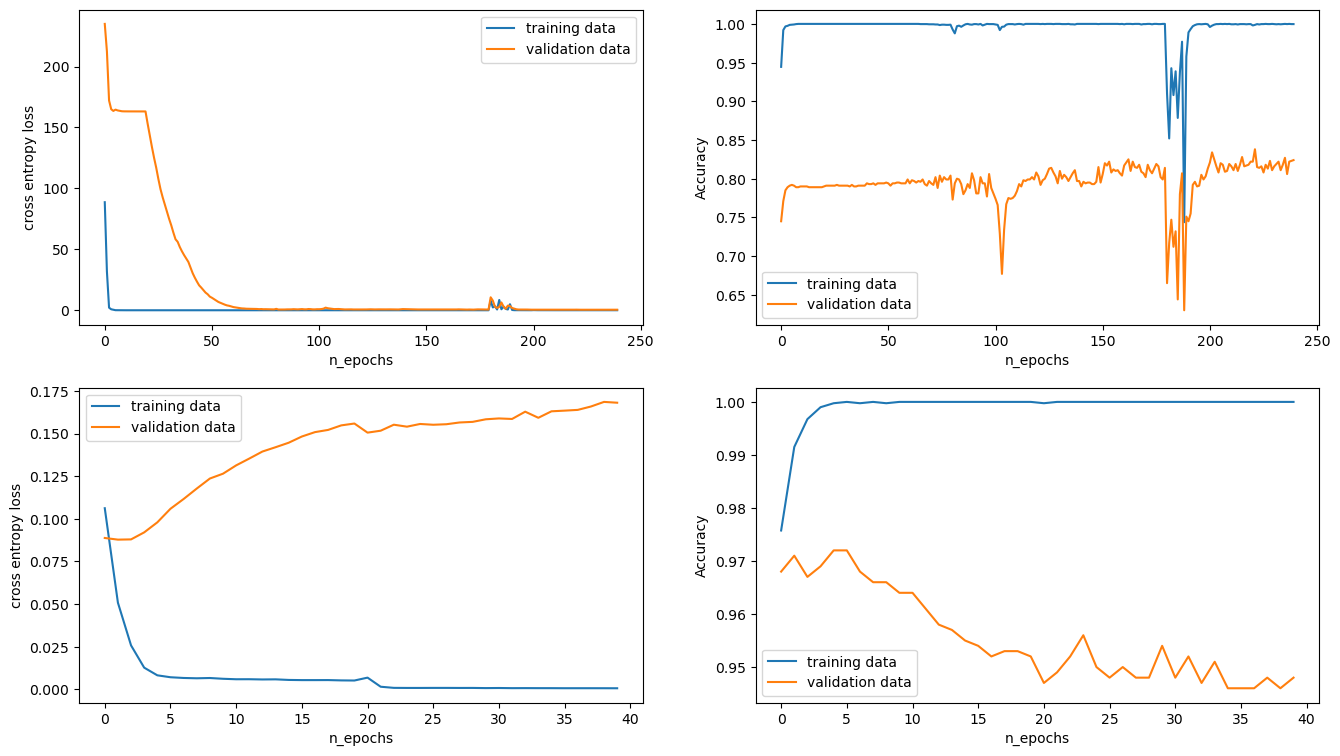

In [37]:
validated_training = [ train_1,
  train_2,
  train_3,
  train_4,
  train_5,
  train_6,
  train_7,
  train_8,
  train_9
]

final_training = [finaltrain_1, finaltrain_2]

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

final_trainloss = []
final_testloss = []
final_trainacc = []
final_testacc = []

for train in validated_training:
    train_losses += train[0]
    test_losses += train[1]
    train_accuracies += train[2]
    test_accuracies += train[3]

for train in final_training:
  final_trainloss += train[0]
  final_testloss += train[1]
  final_trainacc += train[2]
  final_testacc += train[3]
  
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(16,9), dpi=100 )
axs[0,0].plot( range(len(train_losses)), train_losses, label = "training data" )
axs[0,0].plot( range(len(test_losses)), test_losses, label = "validation data" )
axs[0,0].legend()
axs[0,0].set_ylabel("cross entropy loss")
axs[0,0].set_xlabel("n_epochs")

axs[0,1].plot( range(len(train_accuracies)), train_accuracies, label = "training data" )
axs[0,1].plot( range(len(test_accuracies)), test_accuracies, label = "validation data" )
axs[0,1].legend()
axs[0,1].set_ylabel("Accuracy")
axs[0,1].set_xlabel("n_epochs")


axs[1,0].plot( range(len(final_trainloss)), final_trainloss, label = "training data" )
axs[1,0].plot( range(len(final_testloss)), final_testloss, label = "validation data" )
axs[1,0].legend()
axs[1,0].set_ylabel("cross entropy loss")
axs[1,0].set_xlabel("n_epochs")

axs[1,1].plot( range(len(final_trainacc)), final_trainacc, label = "training data" )
axs[1,1].plot( range(len(final_testacc)), final_testacc, label = "validation data" )
axs[1,1].legend()
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xlabel("n_epochs")



In [ ]:
import pickle as pkl
with open("domain1_nn.mdl", "wb") as f:
    pkl.dump( [tfidf_vectorizer, scaler, selector, model], f)